# <a id='toc1_'></a>[Model Evaluation](#toc0_)

This notebook contains the code to evaluate the models on the test set.

**Table of contents**<a id='toc0_'></a>    
- [Model Evaluation](#toc1_)    
- [Import libraries](#toc2_)    
- [Import data](#toc3_)    
- [Prepare data for training](#toc4_)    
  - [Neural network data](#toc4_1_)    
  - [Linear model data](#toc4_2_)    
- [Train Neural Network](#toc5_)    
  - [Constant width](#toc5_1_)    
  - [Pyramid](#toc5_2_)    
- [Train linear models](#toc6_)    
  - [OLS](#toc6_1_)    
  - [LASSO](#toc6_2_)    
  - [Naïve](#toc6_3_)    
- [Summarize the results](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Import libraries](#toc0_)

In [23]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
# from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.compose import ColumnTransformer
# from matplotlib.colors import TwoSlopeNorm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
# from matplotlib.colors import LightSource
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning
from collections import defaultdict


from libs.models import *
from libs.functions import *

plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 4), 'figure.dpi': 300})

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# <a id='toc3_'></a>[Import data](#toc0_)

In [2]:
# read data
df = pd.read_csv('data/data.csv')

# <a id='toc4_'></a>[Prepare data for training](#toc0_)

In [3]:
# prepare expanding window splits
periods = {
    '21' : '2020-01-01', # 2021 is the test set
    '22' : '2021-01-01', # 2022 is the test set
    '23' : '2022-01-01', # 2023 is the test set
    '24': '2023-01-01' # 2024 is the test set
}

# identify dummy vs. numeric columns
feature_cols = [col for col in df.columns if col not in ['timestamp', 'ticker', 'target']]
nace_cols = [c for c in feature_cols if c.startswith('NACE_')]
dummy_cols = ['divi','divo'] # sin removed
macro_cols = ['discount', 'tms', 'dp', 'ep', 'svar'] # 'bm_macro'

# nummeric cols = cols not in cat and macro cols
numeric_cols = [c for c in feature_cols if c not in dummy_cols and c not in nace_cols and c not in macro_cols]

# feature_cols = numeric_cols + dummy_cols + nace_cols # reorder columns to have numeric first

df_raw = df.copy(deep=True)
df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'])

# drop data from 2025
df_raw = df_raw[df_raw['timestamp'] < '2025-01-01']

In [4]:
C = df[numeric_cols].values         # shape = (n_rows, P_c)
X = df[macro_cols].values           # shape = (n_rows, P_x)

# 1) compute all pairwise products with broadcasting:
#    this gives shape (n_rows, P_c, P_x)
K = C[:,:,None] * X[:,None,:]

# 2) reshape to (n_rows, P_c * P_x)
Z = K.reshape(len(df), -1)

# 3) build the column names in the same order
xc_names = [
    f"{c}_x_{m}"
    for c in numeric_cols
    for m in macro_cols
]

# 4) wrap back into a DataFrame
df_xc = pd.DataFrame(Z, columns=xc_names, index=df.index)

feature_cols = numeric_cols + xc_names + dummy_cols + nace_cols
numeric_cols = numeric_cols + xc_names
cat_cols = dummy_cols + nace_cols
df_z = df_raw.merge(df_xc, left_index=True, right_index=True)
# drop macro_cols
df_z = df_z.drop(columns=macro_cols)
# sort columns by feature_cols
df_norm = df_z[['timestamp', 'ticker', 'target'] + feature_cols]

y_values = df_norm['target'].values.astype('float32')


## <a id='toc4_1_'></a>[Neural network data](#toc0_)
Including a validation set

In [5]:
# prepare containers
X_train, X_val, X_test = {}, {}, {}
y_train, y_val, y_test = {}, {}, {}
preprocessors = {}
y_scalers = {}

for y, period in periods.items():
    period = pd.to_datetime(period)

    # split masks
    tr_mask = df_norm['timestamp'] < period
    va_mask = (df_norm['timestamp'] >= period) & \
              (df_norm['timestamp'] - pd.DateOffset(years=1) < period)
    te_mask = (df_norm['timestamp'] - pd.DateOffset(years=1) >= period) & \
              (df_norm['timestamp'] - pd.DateOffset(years=2) < period)

    # extract raw feature DataFrames
    X_tr_df = df_norm.loc[tr_mask, feature_cols].copy()
    X_va_df = df_norm.loc[va_mask, feature_cols].copy()
    X_te_df = df_norm.loc[te_mask, feature_cols].copy()
    y_tr    = y_values[tr_mask]
    y_va    = y_values[va_mask]
    y_te    = y_values[te_mask]

    # compute winsorization bounds on train
    lower = X_tr_df[numeric_cols].quantile(0.01)
    upper = X_tr_df[numeric_cols].quantile(0.99)

    # apply clipping to train, val, test
    X_tr_df[numeric_cols] = X_tr_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)
    X_va_df[numeric_cols] = X_va_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)
    X_te_df[numeric_cols] = X_te_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)


    # now fit scaler on numeric only
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_cols),
        ('cat', 'passthrough',  cat_cols)
    ])
    preprocessor.fit(X_tr_df)
    preprocessors[y] = preprocessor

    # transform all splits
    X_train[y] = preprocessor.transform(X_tr_df).astype('float32')
    X_val[y]   = preprocessor.transform(X_va_df).astype('float32')
    X_test[y]  = preprocessor.transform(X_te_df).astype('float32')

    # fit standard scaler on y values
    y_scaler = StandardScaler()
    y_scaler.fit(y_tr.reshape(-1, 1))
    y_scalers[y] = y_scaler
    y_tr = y_scaler.transform(y_tr.reshape(-1, 1)).flatten()
    y_va = y_scaler.transform(y_va.reshape(-1, 1)).flatten()
    y_te = y_scaler.transform(y_te.reshape(-1, 1)).flatten()


    # store targets as before
    y_train[y] = y_tr.reshape(-1, 1)
    y_val[y]   = y_va.reshape(-1, 1)
    y_test[y]  = y_te.reshape(-1, 1)


## <a id='toc4_2_'></a>[Linear model data](#toc0_)
Excluding the validation set

In [6]:

Xlin_train, Xlin_test = {}, {}
ylin_train, ylin_test = {}, {}
preprocessors_lin = {}

cat_cols_lin = cat_cols + ['const']
feature_cols_lin = feature_cols + ['const']

for y, period in periods.items():
    period = pd.to_datetime(period)
    tr_mask = df_norm['timestamp']- pd.DateOffset(years=1) < period
    te_mask = (df_norm['timestamp'] - pd.DateOffset(years=1) >= period) & \
              (df_norm['timestamp'] - pd.DateOffset(years=2) < period)

    # extract feature DataFrames
    X_tr_df = df_norm.loc[tr_mask, feature_cols]
    X_te_df = df_norm.loc[te_mask, feature_cols]
    y_tr = y_values[tr_mask]
    y_te = y_values[te_mask]

    # add constant column for linear regression
    X_tr_df['const'] = 1
    X_te_df['const'] = 1

    # compute winsorization bounds on train
    lower = X_tr_df[numeric_cols].quantile(0.01)
    upper = X_tr_df[numeric_cols].quantile(0.99)

    # apply clipping to train, test
    X_tr_df[numeric_cols] = X_tr_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)
    X_te_df[numeric_cols] = X_te_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)

    # fit scaler only on training set
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_cols),
        ('cat', 'passthrough', cat_cols_lin)
    ])
    preprocessor.fit(X_tr_df)
    preprocessors_lin[y] = preprocessor

    # ttransform splits
    Xlin_train[y] = preprocessor.transform(X_tr_df).astype('float32')
    Xlin_test[y]  = preprocessor.transform(X_te_df).astype('float32')

    # targets
    ylin_train[y] = y_tr
    ylin_test[y]  = y_te

# <a id='toc5_'></a>[Train Neural Network](#toc0_)

## <a id='toc5_1_'></a>[Constant width](#toc0_)

In [7]:
# moving to metal or CUDA GPU if available
device = torch.device(("cuda" if torch.cuda.is_available() 
                       else "mps" if torch.backends.mps.is_available() 
                       else "cpu"))
print("Using device:", device)

# general hyperparameters
hidden_depth = 4 # only hidden, excluding in- and output layers
hidden_width = 16 # int for all being equal width; list for different widths
learning_rate = 1e-4
activation_fun = nn.ReLU # nn.ReLU nn.Tanh nn.Sigmoid nn.LeakyReLU

# general critereon and regularization parameters
criterion = nn.MSELoss()
lambda_l1 = 1e-5 # 1e-3 # l1 regularization
lambda_l2 = 1e-4 # 1e-4 # l2 regularization
dropout = 0.0

# general parmeters
patience = 25
print_freq = 250
epochs = 250
batch_size = 4096

n_runs = 2 # number of runs for each model to average over


Using device: mps


In [8]:
best_models = {}
history   = {}
mlp_pred  = {}

for y, period in periods.items():
    print(f"\n=== Year {y}: running {n_runs} restarts ===")
    all_run_preds = []

    for run in range(n_runs):
        # set random seed for reproducibility (change for each run)
        seed = 42 + run
        np.random.seed(seed)
        torch.manual_seed(seed)
        print(f"Run {run+1}/{n_runs}, seed={seed}")

        # instantiate a fresh model & optimizer
        input_dim = X_train[y].shape[1]
        model = MLPModel(input_dim,
                         depth=hidden_depth,
                         width=hidden_width,
                         dropout=dropout,
                         activation=activation_fun).to(device)
        optimizer = torch.optim.Adam(model.parameters(),
                                      lr=learning_rate)


        # wrap datasets
        train_ds = MLPdataset(X_train[y], y_train[y])
        val_ds   = MLPdataset(X_val[y],   y_val[y])

        # train
        trained_model, hist = train_mlp(train_ds,
                                        val_ds,
                                        model,
                                        criterion,
                                        epochs,
                                        patience,
                                        print_freq,
                                        device,
                                        optimizer=optimizer,
                                        lambda_l1=lambda_l1,
                                        lambda_l2=lambda_l2,
                                        batch_size=batch_size,
                                        shuffle_train=True,
                                        shuffle_val=False,
                                        save_path=f'models/mlp_y{y}_l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}_run{run+1}.pth'
                                        )

        # predict on test set
        preds = predict_mlp(trained_model,
                            X_test[y],
                            y_test=y_test[y],
                            scaler= y_scalers[y],
                            batch_size=batch_size,
                            device=device)
        all_run_preds.append(preds)

        # optionally store the last run’s model & history
        best_models[(y, run)] = trained_model
        history[(y, run)]     = hist

    # stack (n_runs, n_samples) average over axis=0
    all_run_preds = np.stack(all_run_preds, axis=0)
    mlp_pred[y]   = np.mean(all_run_preds, axis=0)

    print(f"Averaged predictions for year {y} computed.")


=== Year 21: running 2 restarts ===
Run 1/2, seed=42
Early stopping at epoch 34
Best val loss: 7.67487E-01
Model saved to models/mlp_y21_l11e-05_l20.0001_drop0.0_lr0.0001_w16_d4_run1.pth
Run 2/2, seed=43
Early stopping at epoch 170
Best val loss: 7.60042E-01
Model saved to models/mlp_y21_l11e-05_l20.0001_drop0.0_lr0.0001_w16_d4_run2.pth
Averaged predictions for year 21 computed.

=== Year 22: running 2 restarts ===
Run 1/2, seed=42
Early stopping at epoch 37
Best val loss: 4.73750E-01
Model saved to models/mlp_y22_l11e-05_l20.0001_drop0.0_lr0.0001_w16_d4_run1.pth
Run 2/2, seed=43
Early stopping at epoch 54
Best val loss: 4.73764E-01
Model saved to models/mlp_y22_l11e-05_l20.0001_drop0.0_lr0.0001_w16_d4_run2.pth
Averaged predictions for year 22 computed.

=== Year 23: running 2 restarts ===
Run 1/2, seed=42
Early stopping at epoch 48
Best val loss: 4.04737E+00
Model saved to models/mlp_y23_l11e-05_l20.0001_drop0.0_lr0.0001_w16_d4_run1.pth
Run 2/2, seed=43
Early stopping at epoch 35
Bes

## <a id='toc5_2_'></a>[Pyramid](#toc0_)

In [9]:
# training model with most data on multiple parameters
hidden_depth_pyr = None
hidden_width_pyr = [32, 16, 8]

In [10]:
best_models_pyr = {}
history_pyr   = {}
mlp_pred_pyr  = {}

for y, period in periods.items():
    print(f"\n=== Year {y}: running {n_runs} restarts ===")
    all_run_preds = []

    for run in range(n_runs):
        # set random seed for reproducibility (change for each run)
        seed = 42 + run
        np.random.seed(seed)
        torch.manual_seed(seed)
        print(f"Run {run+1}/{n_runs}, seed={seed}")

        # instantiate a fresh model & optimizer
        input_dim = X_train[y].shape[1]
        model = MLPModel(input_dim,
                         depth=len(hidden_width_pyr),
                         width=hidden_width_pyr,
                         dropout=dropout,
                         activation=activation_fun).to(device)
        optimizer = torch.optim.Adam(model.parameters(),
                                      lr=learning_rate)


        # wrap datasets
        train_ds = MLPdataset(X_train[y], y_train[y])
        val_ds   = MLPdataset(X_val[y],   y_val[y])

        # train
        trained_model, hist = train_mlp(train_ds,
                                        val_ds,
                                        model,
                                        criterion,
                                        epochs,
                                        patience,
                                        print_freq,
                                        device,
                                        optimizer=optimizer,
                                        lambda_l1=lambda_l1,
                                        lambda_l2=lambda_l2,
                                        batch_size=batch_size,
                                        shuffle_train=True,
                                        shuffle_val=False,
                                        save_path=f'models/mlp_y{y}_l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}_run{run+1}.pth'
                                        )

        # predict on test set
        preds = predict_mlp(trained_model,
                            X_test[y],
                            y_test=y_test[y],
                            scaler= y_scalers[y], # preprocessors[y] if hasattr(preprocessors[y], 'inverse_transform') else None,
                            batch_size=batch_size,
                            device=device)
        all_run_preds.append(preds)

        # optionally store the last run’s model & history
        best_models_pyr[(y, run)] = trained_model
        history_pyr[(y, run)]     = hist

    # stack (n_runs, n_samples) average over axis=0
    all_run_preds = np.stack(all_run_preds, axis=0)
    mlp_pred_pyr[y]   = np.mean(all_run_preds, axis=0)

    print(f"Averaged predictions for year {y} computed.")


=== Year 21: running 2 restarts ===
Run 1/2, seed=42
Early stopping at epoch 164
Best val loss: 7.62579E-01
Model saved to models/mlp_y21_l11e-05_l20.0001_drop0.0_lr0.0001_w16_d4_run1.pth
Run 2/2, seed=43
Early stopping at epoch 161
Best val loss: 7.59860E-01
Model saved to models/mlp_y21_l11e-05_l20.0001_drop0.0_lr0.0001_w16_d4_run2.pth
Averaged predictions for year 21 computed.

=== Year 22: running 2 restarts ===
Run 1/2, seed=42
Early stopping at epoch 76
Best val loss: 4.68042E-01
Model saved to models/mlp_y22_l11e-05_l20.0001_drop0.0_lr0.0001_w16_d4_run1.pth
Run 2/2, seed=43
Early stopping at epoch 78
Best val loss: 4.68947E-01
Model saved to models/mlp_y22_l11e-05_l20.0001_drop0.0_lr0.0001_w16_d4_run2.pth
Averaged predictions for year 22 computed.

=== Year 23: running 2 restarts ===
Run 1/2, seed=42
Early stopping at epoch 67
Best val loss: 4.02930E+00
Model saved to models/mlp_y23_l11e-05_l20.0001_drop0.0_lr0.0001_w16_d4_run1.pth
Run 2/2, seed=43
Early stopping at epoch 46
Be

# <a id='toc6_'></a>[Train linear models](#toc0_)

## <a id='toc6_1_'></a>[OLS](#toc0_)

In [11]:
# linear model
# estimate the parameters
ols_est = {}
ols_pred = {}
ols_coefs = {}


for y in periods.keys():
    print(f"Estimating OLS for {y}...")
    x_tr = Xlin_train[y]
    y_tr = ylin_train[y]
    x_te = Xlin_test[y]
    y_te = ylin_test[y]


    # estimate the parameters
    ols_est[y] = estimate(y_tr, x_tr)
    # ols_pred_train[y] = ols_est[y]['b_hat'] @ x_tr.T
    ols_pred[y] = ols_est[y]['b_hat'] @ x_te.T
    ols_coefs[y] = ols_est[y]['b_hat']

Estimating OLS for 21...
Estimating OLS for 22...
Estimating OLS for 23...


/Users/johan/Documents/04 Uni/10 Thesis/git/MastersThesis/libs/functions.py:194: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(cov)).reshape(-1, 1)


Estimating OLS for 24...


In [12]:
ols_coefs_df = pd.DataFrame(ols_coefs, index=feature_cols_lin)

## <a id='toc6_2_'></a>[LASSO](#toc0_)

In [13]:
# linear model
# create a grid using numpy.geomspace
penalty_grid = np.geomspace(1e-7, 100, num = 1000)
lasso_est = {}
# lasso_pred_train = {}
lasso_pred = {}
lasso_coefs = {}


with warnings.catch_warnings():
    warnings.simplefilter("ignore", ConvergenceWarning)
    for y in periods.keys():
        print(f"Estimating LASSO for {y}...")
        x_tr = Xlin_train[y]
        y_tr = ylin_train[y]
        x_te = Xlin_test[y]
        y_te = ylin_test[y]

        # estimate the model using LassoCV
        fit_CV = LassoCV(cv=5, alphas=penalty_grid, max_iter=1000, eps=1e-3, n_jobs=-1).fit(x_tr,y_tr)
        # lasso_pred_train[y] = fit_CV.predict(x_tr)
        lasso_pred[y] = fit_CV.predict(x_te)

        # store the coefficients
        coef = fit_CV.coef_
        lasso_coefs[y] = coef


Estimating LASSO for 21...
Estimating LASSO for 22...
Estimating LASSO for 23...
Estimating LASSO for 24...


In [14]:
lasso_coefs_df = pd.DataFrame(lasso_coefs, index=feature_cols_lin)

## <a id='toc6_3_'></a>[Naïve](#toc0_)

In [15]:
naive_pred = {}

for y in periods.keys():
    # naive prediction is the mean of the training set
    pred = np.mean(ylin_train[y])
    naive_pred[y] = np.full_like(ylin_test[y], pred, dtype=np.float32)

# <a id='toc7_'></a>[Summarize the results](#toc0_)

In [16]:
pred_dfs = []

for y, period in periods.items():
    # rebuild masks
    te_mask = ((df_norm['timestamp'] - pd.DateOffset(years=1) >= period) &
               (df_norm['timestamp'] - pd.DateOffset(years=2) <  period))
    X_te_df = df_norm.loc[te_mask, feature_cols]
    idx = X_te_df.index


    pred_dfs.append(pd.DataFrame({
        'period':    y,
        'timestamp': df_norm.loc[idx, 'timestamp'],
        'ticker':    df_norm.loc[idx, 'ticker'],
        'y_true':    df_norm.loc[idx, 'target'].values.astype('float32'),
        'discount':  df.loc[idx, 'discount'].values.astype('float32'),
        'Naïve':  naive_pred[y],
        'OLS':    ols_pred[y].flatten(),
        'LASSO':  lasso_pred[y],
        'MLP':    mlp_pred[y],
        'MLP-Pyr': mlp_pred_pyr[y],
    }, index=idx))

all_preds = pd.concat(pred_dfs).sort_index()

# create full return numbers
all_preds['discount_month'] = (1 + all_preds['discount'])**(1/12)-1
all_preds['y_true_full'] = all_preds['y_true'] + all_preds['discount_month']
all_preds['Naïve_full'] = all_preds['Naïve'] + all_preds['discount_month']
all_preds['OLS_full'] = all_preds['OLS'] + all_preds['discount_month']
all_preds['LASSO_full'] = all_preds['LASSO'] + all_preds['discount_month']
all_preds['MLP_full'] = all_preds['MLP'] + all_preds['discount_month']
all_preds['MLP-Pyr_full'] = all_preds['MLP-Pyr'] + all_preds['discount_month']

# save predictions
# all_preds.to_csv('data/predictions.csv', index=True)

In [17]:
metrics_full = {}
results_full = {}
methods = ['Naïve',
           'OLS', 
           'LASSO', 
           'MLP',
           'MLP-Pyr',
           ]
for method in methods:
    for y, period in periods.items():
        y_true = all_preds.loc[all_preds['period'] == y, 'y_true']
        y_pred = all_preds.loc[all_preds['period'] == y, method]
        y_true_full = all_preds.loc[all_preds['period'] == y, f'y_true_full']
        y_pred_full = all_preds.loc[all_preds['period'] == y, f'{method}_full']
        key = f'{method}{y}'
        results_full[key] = {
            'RMSE': rmse_fun(y_pred, y_true),
            'MAE': mae_fun(y_pred, y_true),
            'MADL': madl_fun(y_pred_full, y_true_full),
            'AMADL': amadl_fun(y_pred_full, y_true_full, delta=0.5)
        }
    key = f'{method}Total'
    results_full[key] = {
        'RMSE': rmse_fun(all_preds[method], all_preds['y_true']),
        'MAE': mae_fun(all_preds[method], all_preds['y_true']),
        'MADL': madl_fun(all_preds[f'{method}_full'], all_preds['y_true_full']),
        'AMADL' : amadl_fun(all_preds[f'{method}_full'], all_preds['y_true_full'], delta=0.5)
    }
    
for y in list(periods.keys()) + ['Total']:
    if y != 'Total':
        name = '20' + y
    else:
        name = y
    for metric in ['RMSE',
                   'MAE',
                   'MADL',
                   'AMADL']:
        key = f'*{metric}*{name}'
        vals = [
            results_full[f'Naïve{y}'][metric],
            results_full[f'OLS{y}'][metric],
            results_full[f'LASSO{y}'][metric],
            results_full[f'MLP{y}'][metric],
            results_full[f'MLP-Pyr{y}'][metric],
        ]
        metrics_full[key] = vals

tab_full = latex_table_grouped(methods,metrics_full)

# with open('tabs/prediction_results.tex', 'w') as f:
#     f.write(tab_full)
print(tab_full)


\begin{tabular}{clccccc}
\hline\hline \\ [-1.8ex]
 &  & Naïve & OLS & LASSO & MLP & MLP-Pyr \\ 
 \hline 
\multirow[c]{5}{*}{\rotatebox{90}{RMSE}} 
& 2021 & 0.11019 & 0.11697 & 0.10895 & 0.11025 & 0.10914 \\ 
 & 2022 & 0.31761 & 0.32097 & 0.31817 & 0.31775 & 0.31774 \\ 
 & 2023 & 0.11345 & 0.12683 & 0.11483 & 0.11288 & 0.11403 \\ 
 & 2024 & 0.15875 & 0.16596 & 0.16129 & 0.15935 & 0.15920 \\ 
 & Total & 0.19457 & 0.20040 & 0.19532 & 0.19467 & 0.19464 \\ 
\hline\multirow[c]{5}{*}{\rotatebox{90}{MAE}} 
& 2021 & 0.07187 & 0.08267 & 0.07238 & 0.07332 & 0.07459 \\ 
 & 2022 & 0.09620 & 0.10512 & 0.10074 & 0.09753 & 0.10011 \\ 
 & 2023 & 0.06932 & 0.08146 & 0.06964 & 0.06815 & 0.06870 \\ 
 & 2024 & 0.07233 & 0.08019 & 0.07404 & 0.07206 & 0.07151 \\ 
 & Total & 0.07749 & 0.08743 & 0.07925 & 0.07784 & 0.07882 \\ 
\hline\multirow[c]{5}{*}{\rotatebox{90}{MADL}} 
& 2021 & -0.01775 & -0.01981 & -0.01958 & -0.01822 & -0.02179 \\ 
 & 2022 & -0.01242 & 0.00566 & 0.00074 & -0.00168 & -0.00127 \\ 
 & 2023

In [18]:
# # ------------------------------------------------------------
# # helpers
# # ------------------------------------------------------------
# import numpy as np
# import torch
# from sklearn.metrics import r2_score
# import numpy as np
# import torch
# import torch.nn.functional as F

# def r2_score_torch(y_true, y_pred):
#     """Compute R² the same way sklearn does, but on torch tensors."""
#     ss_res = torch.sum((y_true - y_pred) ** 2)
#     ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
#     return 1.0 - ss_res / ss_tot

# def mse_torch(y_true, y_pred):
#     """Compute MSE the same way sklearn does, but on torch tensors."""
#     return  torch.sum((y_true - y_pred) ** 2)

# def var_importance(
#     model: torch.nn.Module,
#     X: np.ndarray,
#     y: np.ndarray,
#     device: torch.device = torch.device("cpu"),
# ) -> np.ndarray:
#     """
#     Return the vector of ΔR²_j = R²_base – R²( x_j := 0 ) for each column j.
#     The vector is normalised to sum to 1.
#     """
#     model.eval()
#     with torch.no_grad():
#         # baseline fit
#         X_t = torch.tensor(X, dtype=torch.float32, device=device)
#         y_t = torch.tensor(y, dtype=torch.float32, device=device)
#         base_mse = mse_torch(y_t, model(X_t)).item()

#         importances = np.zeros(X.shape[1], dtype=np.float64)

#         # loop over predictors
#         for j in range(X.shape[1]):
#             X_zero = X_t.clone()
#             X_zero[:, j] = 0.0                      # zero-out j
#             mse_j = mse_torch(y_t, model(X_zero)).item()
#             importances[j] = mse_j - base_mse         # loss in fit

#     # avoid negative round-off
#     importances = np.clip(importances, 0, None)
#     if importances.sum() > 0:
#         importances /= importances.sum()            # normalise to 1
#     return importances

# def group_label(name: str) -> str:
#     """
#     1. Strip everything after the first '_x_'             →  interaction terms
#     2. Collapse every feature that begins with 'NACE_'    →  'NACE'
#     """
#     base = name.split('_x_', 1)[0]            # rule 1
#     return 'NACE' if base.startswith('NACE_') else base   # rule 2



In [19]:
# period_order   = list(periods.keys())             # ['21','22','23','24']
# run_order      = list(range(n_runs))              # [0,1,2]

# # (period, run)  → importance vector
# imp_vectors = {}

# for y in period_order:
#     X_eval = X_test[y]                            # or X_val[y] / X_train[y]
#     y_eval = y_test[y].flatten()                  # already standardised
#     for r in run_order:
#         key = (y, r)
#         model = best_models[key]
#         imp_vectors[key] = var_importance(model, X_eval, y_eval, device)


# # average over the 3 restarts inside each period
# imp_avg = { y: np.mean([imp_vectors[(y,r)] for r in run_order], axis=0)
#             for y in period_order }

# # build a matrix for the heat-map: rows = features, cols = periods
# imp_mat = np.column_stack([imp_avg[y] for y in period_order])
# imp_df  = pd.DataFrame(imp_mat, index=feature_cols, columns=period_order)

# base_names = pd.Series(imp_df.index).map(group_label).values

# imp_df_agg = (
#     imp_df
#       .assign(base = base_names)
#       .groupby('base', sort=False)
#       .sum()
# )

# # optional: sort rows by mean importance
# imp_df_agg = imp_df_agg.loc[
#     imp_df_agg.mean(axis=1).sort_values(ascending=False).index
# ]

# fig, ax = plt.subplots(figsize=(8, 0.25 * len(imp_df_agg)))

# im = ax.imshow(imp_df_agg.values, aspect='auto')
# ax.set_yticks(np.arange(len(imp_df_agg.index)))
# ax.set_yticklabels(imp_df_agg.index, fontsize=6)
# ax.set_xticks(np.arange(len(period_order)))
# ax.set_xticklabels(period_order)
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# cbar = fig.colorbar(im, ax=ax, fraction=0.02, pad=0.02)
# cbar.ax.set_ylabel("Normalised MSE",
#                    rotation=-90, va="bottom")

# fig.tight_layout()
# # plt.show()



In [20]:
# def mse_torch(y_true, y_pred):
#     return torch.sum((y_true - y_pred) ** 2)

# def importance_nn(model, X, y, device):
#     model.eval()
#     with torch.no_grad():
#         X_t = torch.tensor(X, dtype=torch.float32, device=device)
#         y_t = torch.tensor(y, dtype=torch.float32, device=device)
#         base = mse_torch(y_t, model(X_t)).item()

#         imp = np.zeros(X.shape[1])
#         for j in range(X.shape[1]):
#             Xz = X_t.clone();  Xz[:, j] = 0.
#             imp[j] = mse_torch(y_t, model(Xz)).item() - base
#     imp = np.clip(imp, 0, None)
#     if imp.sum() > 0: imp /= imp.sum()
#     return imp

# def importance_lin(beta, X, y, const=None, feature=None):
#     y_hat  = X @ beta 
#     base   = ((y - y_hat) ** 2).sum()

#     # contribution of each regressor
#     imp = np.zeros_like(beta)
#     for j in range(len(beta)):
#         if beta[j] == 0:        # skip early for sparsity in LASSO
#             continue
#         elif const is not None and feature[j] == const: # skip constant term
#             continue
#         y_hat_minus_j = y_hat - X[:, j] * beta[j]
#         mse_j = ((y - y_hat_minus_j) ** 2).sum()
#         imp[j] = mse_j - base

#     imp = np.clip(imp, 0, None)
    
#     # drop constant term if present
#     if const is not None:
#         const_idx = feature.index(const)
#         imp = np.delete(imp, const_idx)

#     if imp.sum() > 0: imp /= imp.sum()
#     return imp

# def group_label(name: str) -> str:
#     base = name.split('_x_', 1)[0]
#     return 'NACE' if base.startswith('NACE_') else base


In [24]:
period_order   = list(periods.keys())             # ['21','22','23','24']
run_order      = list(range(n_runs))              # [0,1,2]

imp_by_model_year = defaultdict(list)

# ols and lasso
for y in period_order:
    X_eval, y_eval = Xlin_test[y], ylin_test[y].flatten()

    beta_ols    = ols_coefs_df[y].loc[feature_cols_lin].values
    beta_lasso  = lasso_coefs_df[y].loc[feature_cols_lin].values 

    imp_by_model_year['OLS'].append(
        importance_lin(beta_ols, X_eval, y_eval, const='const', 
                       feature=feature_cols_lin)
    )
    imp_by_model_year['LASSO'].append(
        importance_lin(beta_lasso, X_eval, y_eval, const='const', 
                       feature=feature_cols_lin)
    )

# constant width mlp
for y in period_order:
    X_eval, y_eval = X_test[y], y_test[y].flatten()

    # mean across runs first
    imp_runs = []
    for r in run_order:
        model = best_models[(y, r)]
        imp_runs.append(importance_nn(model, X_eval, y_eval, device))
    imp_by_model_year['MLP'].append( np.mean(imp_runs, axis=0) )

# pyramid model
for y in period_order:
    X_eval, y_eval = X_test[y], y_test[y].flatten()

    imp_runs = []
    for r in run_order:
        model = best_models_pyr[(y, r)]
        imp_runs.append(importance_nn(model, X_eval, y_eval, device))
    imp_by_model_year['MLP-pyr'].append( np.mean(imp_runs, axis=0) )

In [25]:
imp_by_model = {
    m : np.mean(vectors, axis=0)           # arithmetic mean over years
    for m, vectors in imp_by_model_year.items()
}

# build a single DataFrame  (rows = features, cols = models)
imp_df = pd.DataFrame(
    { m : vec for m, vec in imp_by_model.items() },
    index = feature_cols
)

base_names = pd.Series(imp_df.index).map(group_label).values
imp_df_agg = (
    imp_df
      .assign(base = base_names)
      .groupby('base', sort=False)
      .sum()
)

# optional: order rows by overall importance
imp_df_agg = imp_df_agg.loc[
    imp_df_agg.mean(axis=1).sort_values(ascending=False).index
]

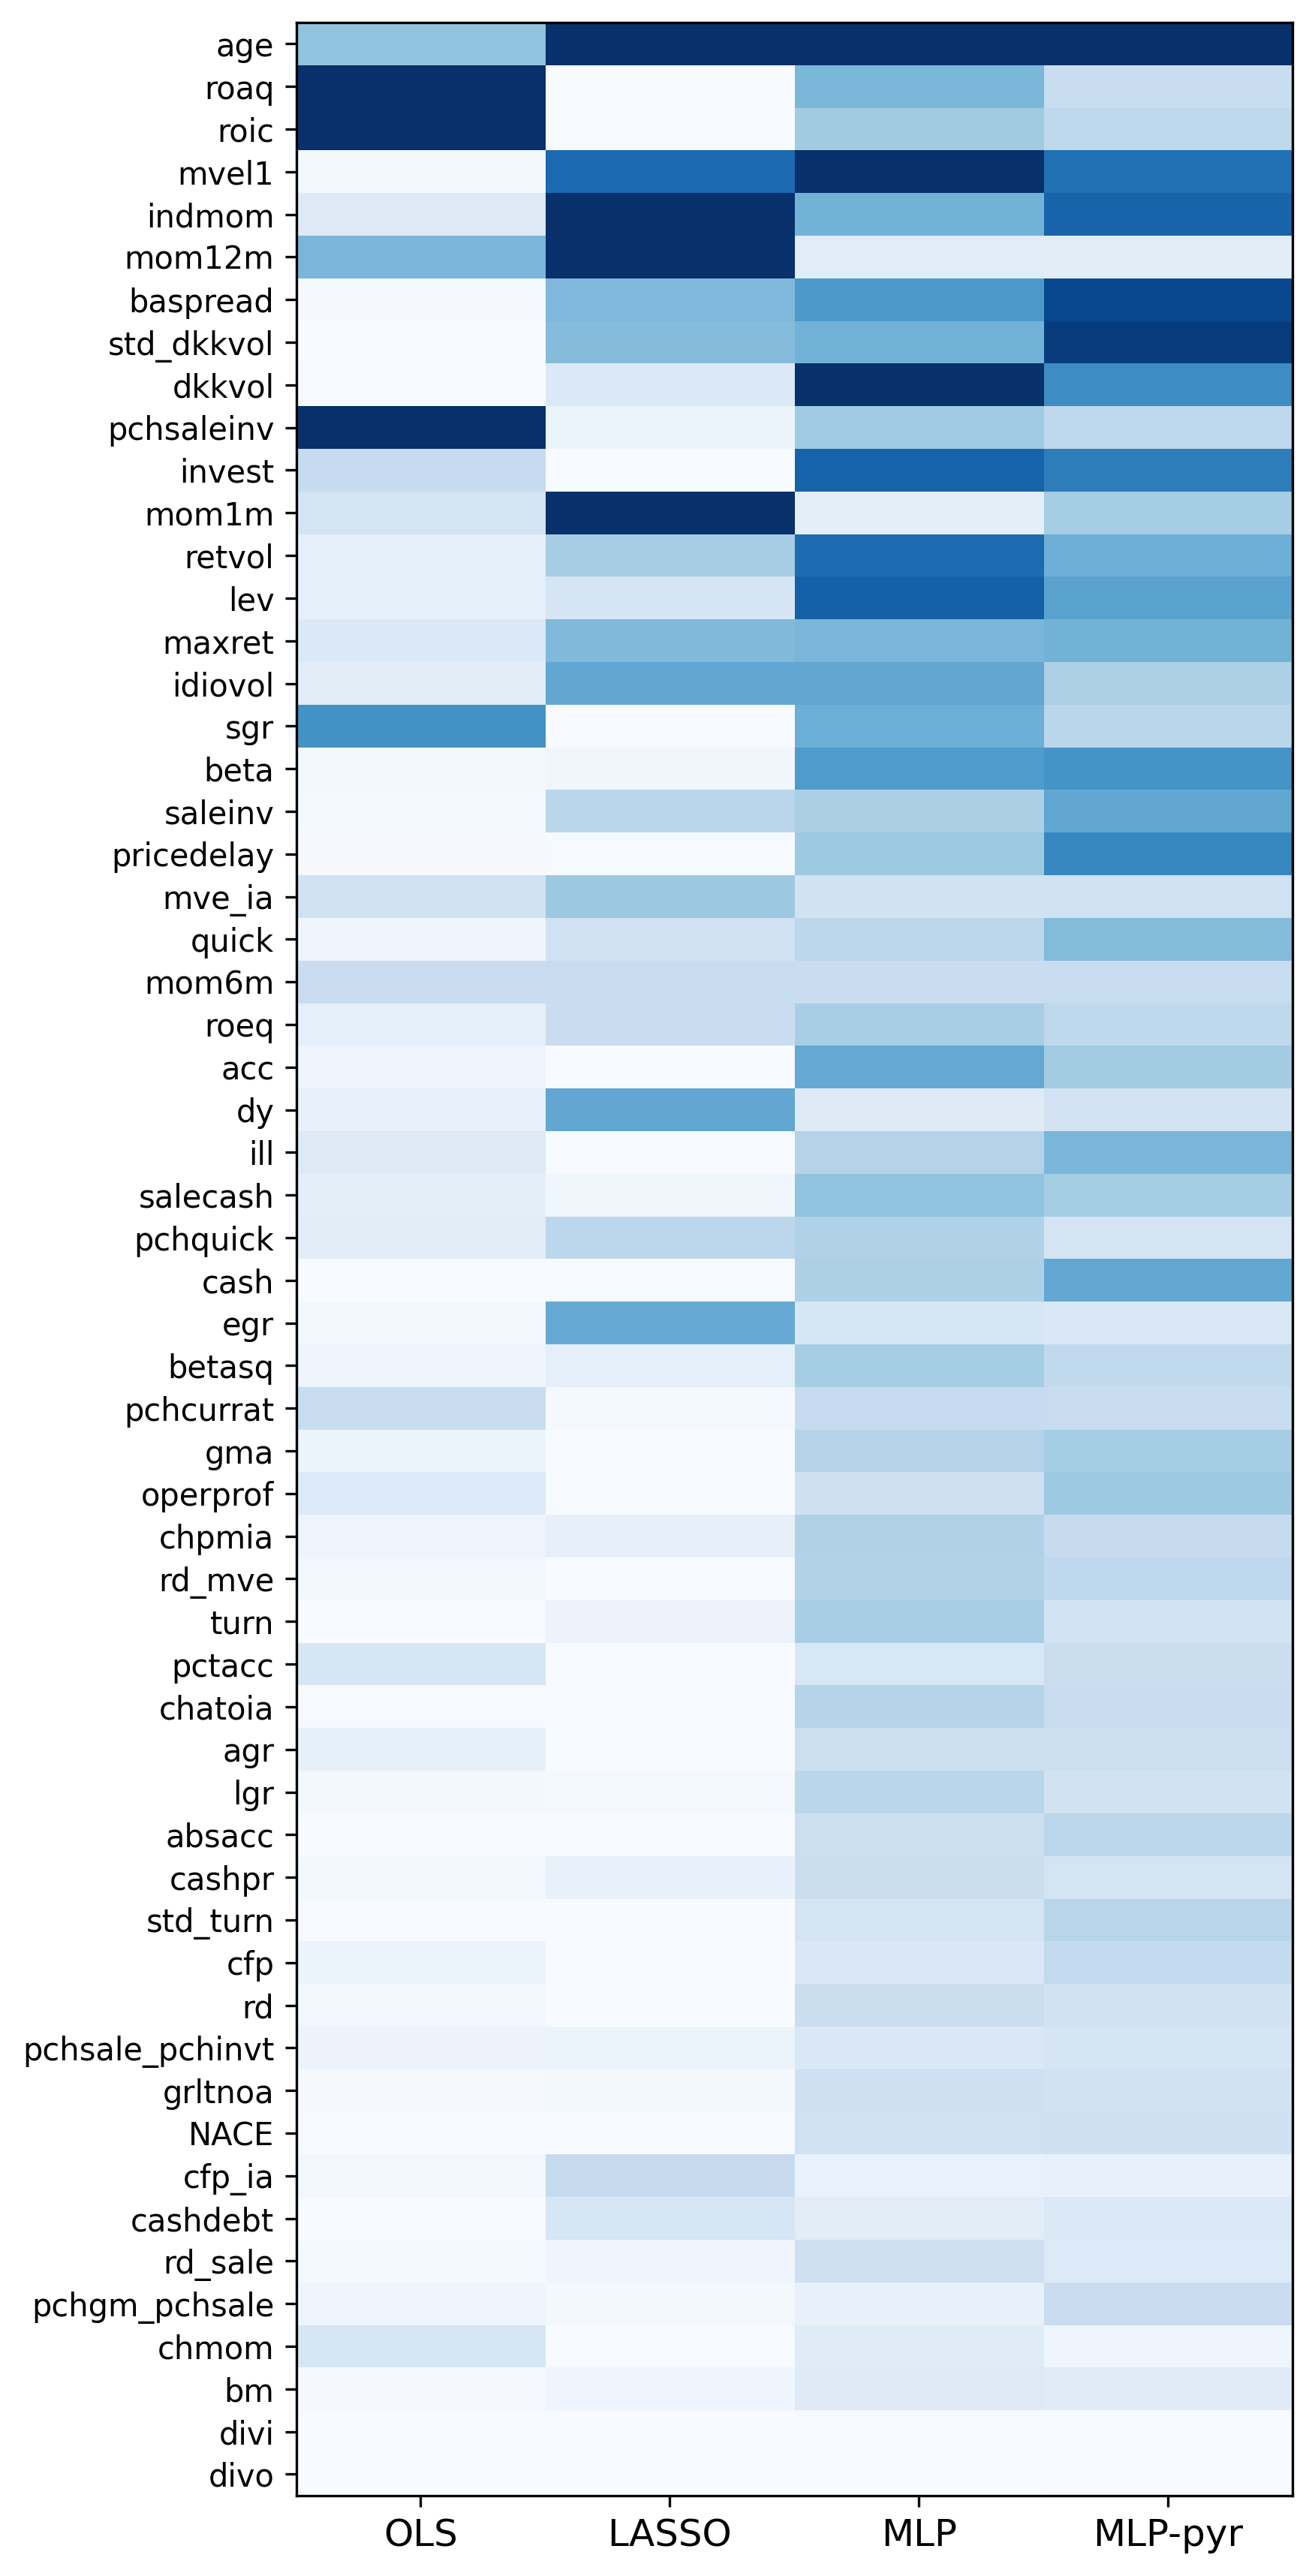

In [35]:
fig, ax = plt.subplots(figsize=(1.5*len(imp_df_agg.columns),
                                0.2*len(imp_df_agg)))

im = ax.imshow(imp_df_agg.values, aspect='auto', cmap='Blues', vmin=0, vmax=0.05)
ax.set_xticks(np.arange(len(imp_df_agg.columns)))
ax.set_xticklabels(imp_df_agg.columns, ha='center')
ax.set_yticks(np.arange(len(imp_df_agg.index)))
ax.set_yticklabels(imp_df_agg.index, fontsize=10)

# cbar = fig.colorbar(im, ax=ax, fraction=0.02, pad=0.02)
# cbar.ax.set_ylabel("Normalised $\Delta$MSE",
#                    rotation=-90, va='bottom')

fig.tight_layout()
plt.savefig('figs/variable_importance.png', bbox_inches='tight')
plt.show()


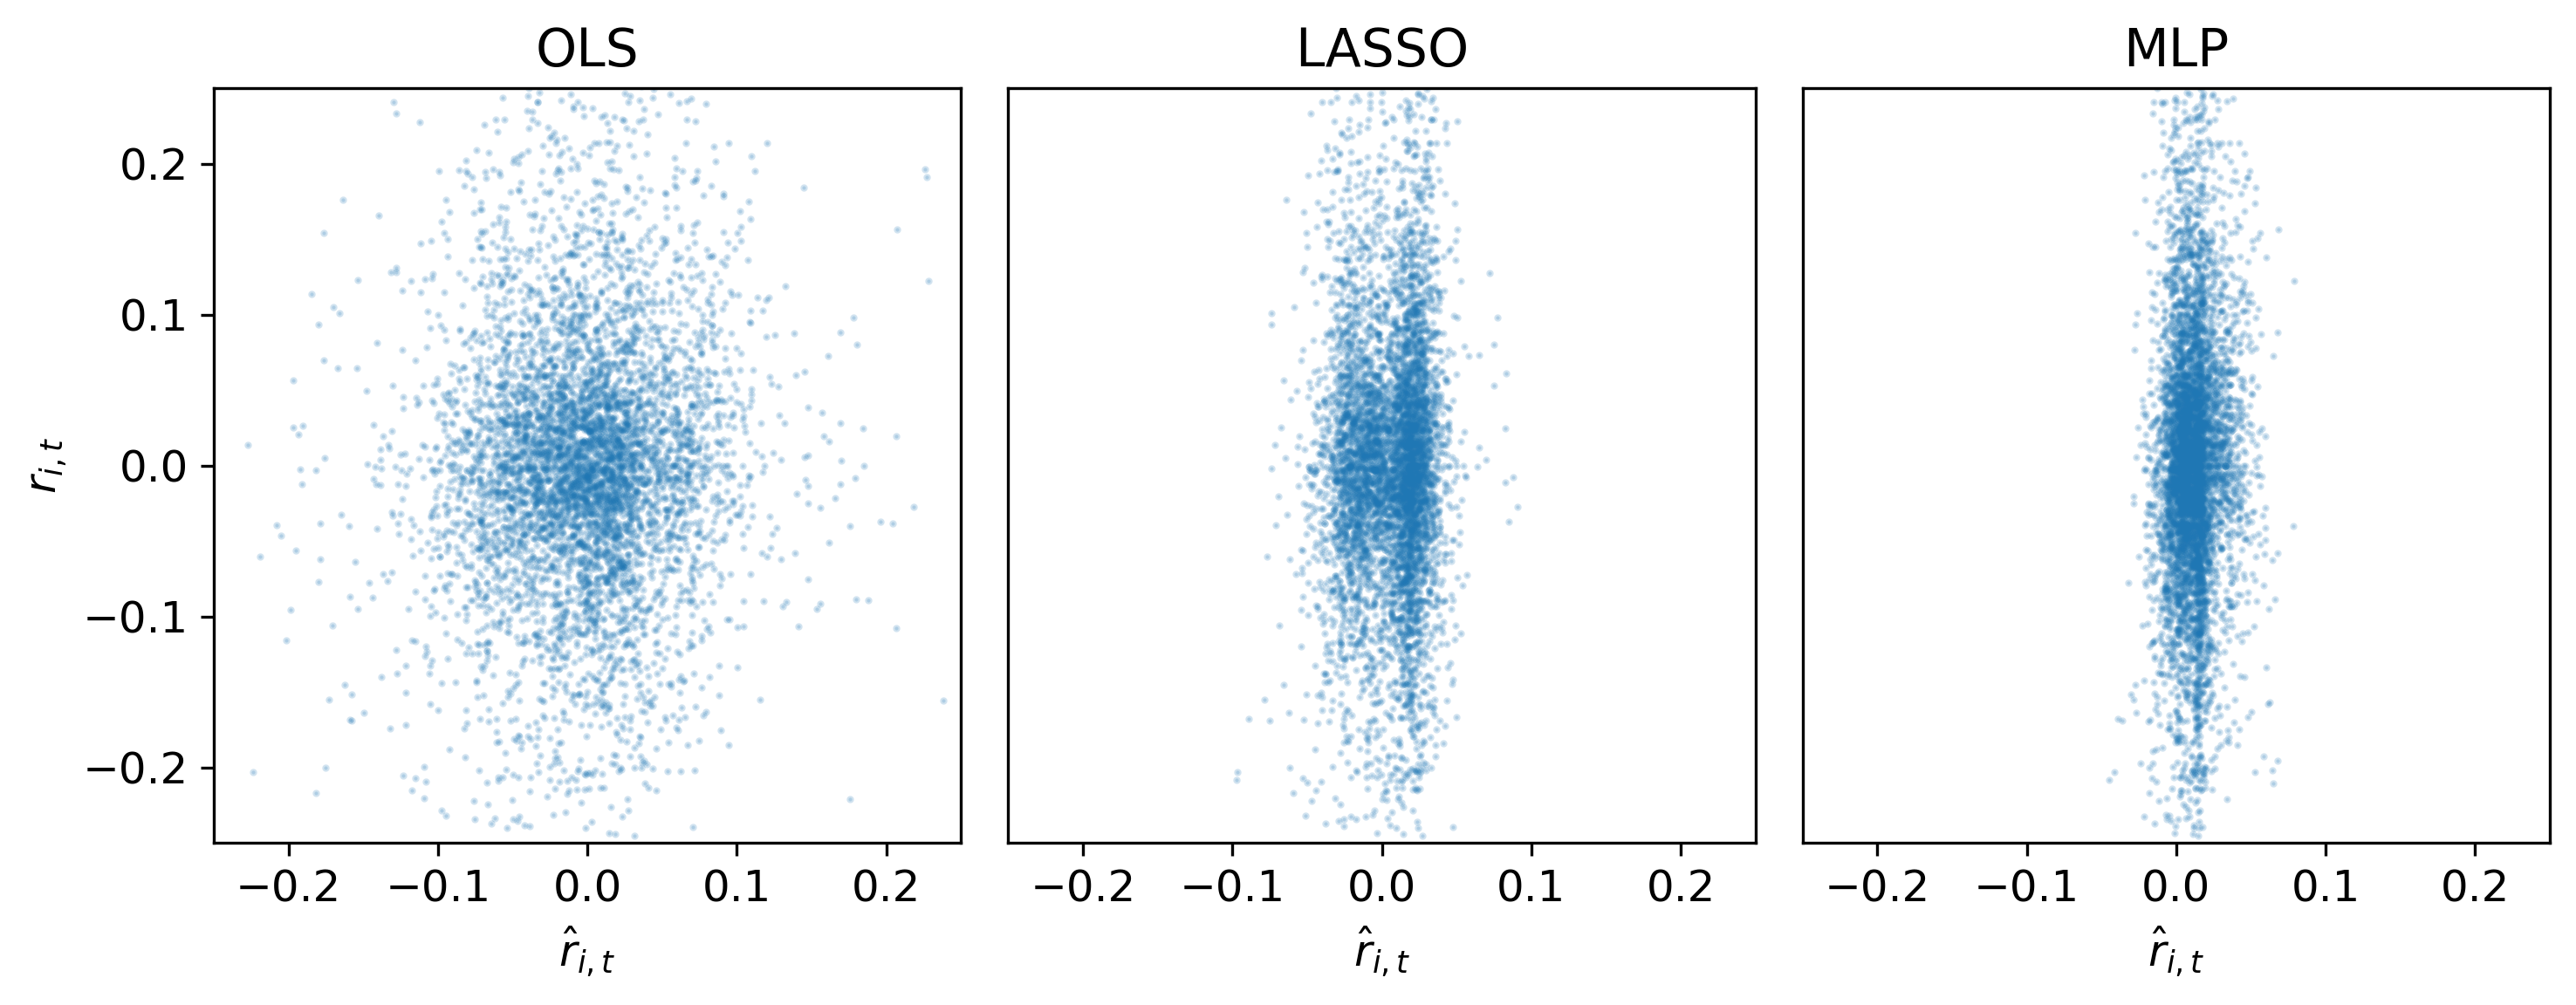

In [ ]:
# # plot y_true vs. y_pred in scatter
# y_min, y_max = -0.25, 0.25

# plt.subplot(1,3,1)
# plt.scatter(all_preds['OLS'], all_preds['y_true'], alpha=0.2, s=1)
# plt.ylabel('$r_{i,t}$')
# plt.xlabel('$\hat{r}_{i,t}$')
# # plt.yticks(np.arange(-0.3, 0.3, 0.1), fontsize=14)
# plt.ylim(y_min, y_max)
# plt.xlim(y_min, y_max)
# plt.title('OLS')
# plt.subplot(1,3,2)
# plt.scatter(all_preds['LASSO'], all_preds['y_true'], alpha=0.2, s=1)
# plt.xlabel('$\hat{r}_{i,t}$')
# # plt.ylabel('y_pred')
# plt.ylim(y_min, y_max)
# plt.xlim(y_min, y_max)
# plt.yticks([])    
# plt.title('LASSO')
# plt.subplot(1,3,3)
# plt.scatter(all_preds['MLP'], all_preds['y_true'], alpha=0.2, s=1)
# plt.xlabel('$\hat{r}_{i,t}$')
# # plt.ylabel('y_pred')
# plt.ylim(y_min, y_max)
# plt.xlim(y_min, y_max)
# plt.yticks([])    
# plt.title('MLP')
# plt.tight_layout()
# plt.savefig('figs/y_true_vs_y_pred.png', dpi=300)
# plt.show()
# plt.close()


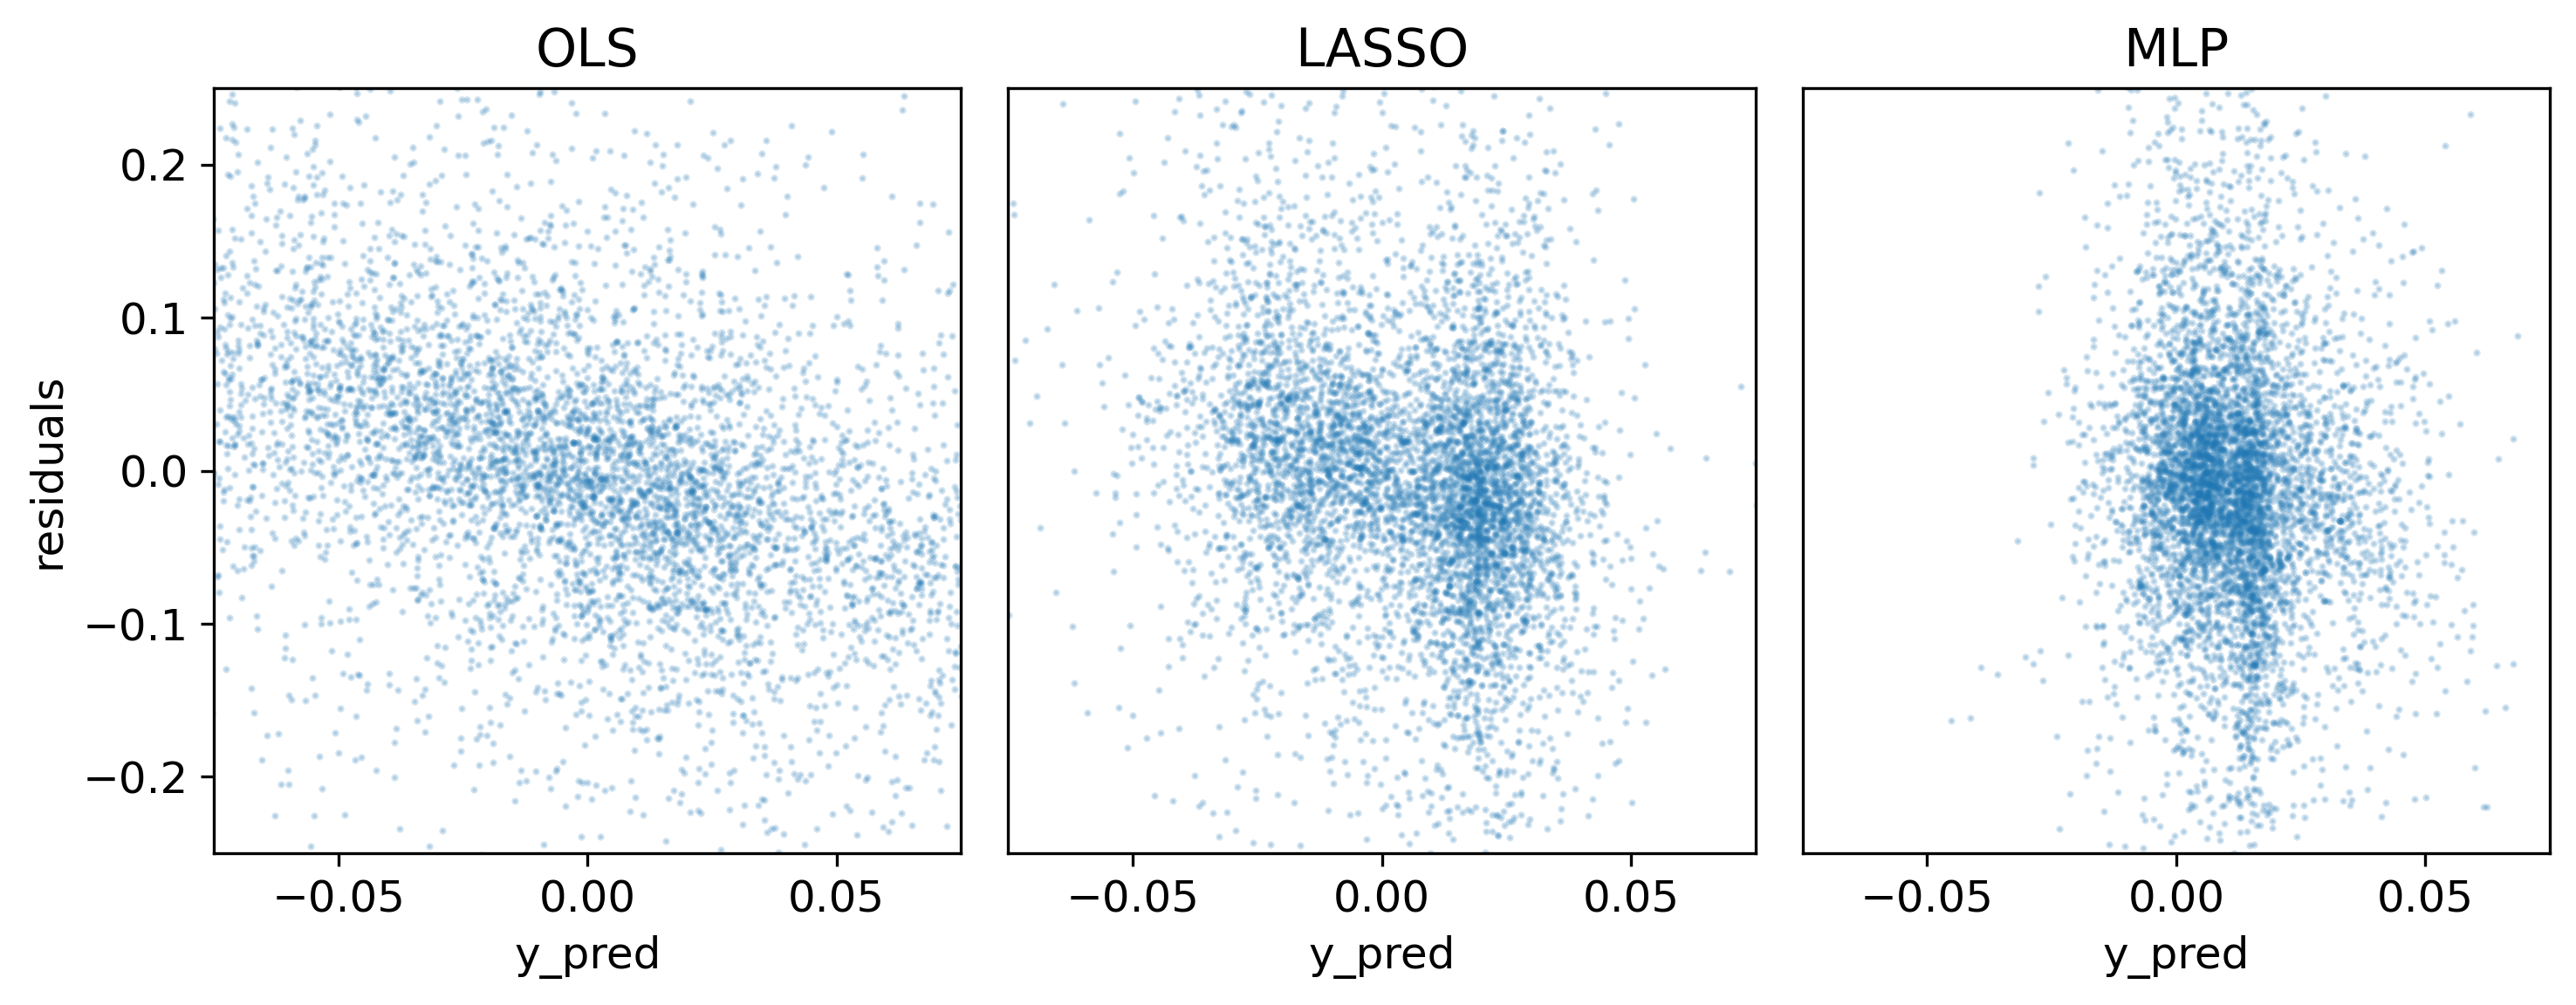

In [ ]:
# # plot y_true vs. y_pred in scatter
# y_min, y_max = -0.25, 0.25

# plt.subplot(1,3,1)
# plt.scatter(all_preds['OLS'], all_preds['y_true']-all_preds['OLS'], alpha=0.2, s=1)
# plt.xlabel('y_pred')
# plt.ylabel('residuals')
# # plt.yticks(np.arange(-0.3, 0.3, 0.1), fontsize=14)
# plt.ylim(y_min, y_max)
# plt.xlim(-0.075, 0.075)
# plt.title('OLS')
# plt.subplot(1,3,2)
# plt.scatter(all_preds['LASSO'], all_preds['y_true']-all_preds['LASSO'], alpha=0.2, s=1)
# plt.xlabel('y_pred')
# # plt.ylabel('y_pred')
# plt.ylim(y_min, y_max)
# plt.xlim(-0.075, 0.075)
# plt.yticks([])  
# plt.title('LASSO')
# plt.subplot(1,3,3)
# plt.scatter(all_preds['MLP'], all_preds['y_true']-all_preds['MLP'], alpha=0.2, s=1)
# plt.xlabel('y_pred')
# # plt.ylabel('y_pred')
# plt.ylim(y_min, y_max)
# plt.xlim(-0.075, 0.075)
# plt.yticks([])  
# plt.title('MLP')
# plt.tight_layout()
# # plt.savefig('figs/y_true_vs_error.png', dpi=300)
# plt.show()
# plt.close()


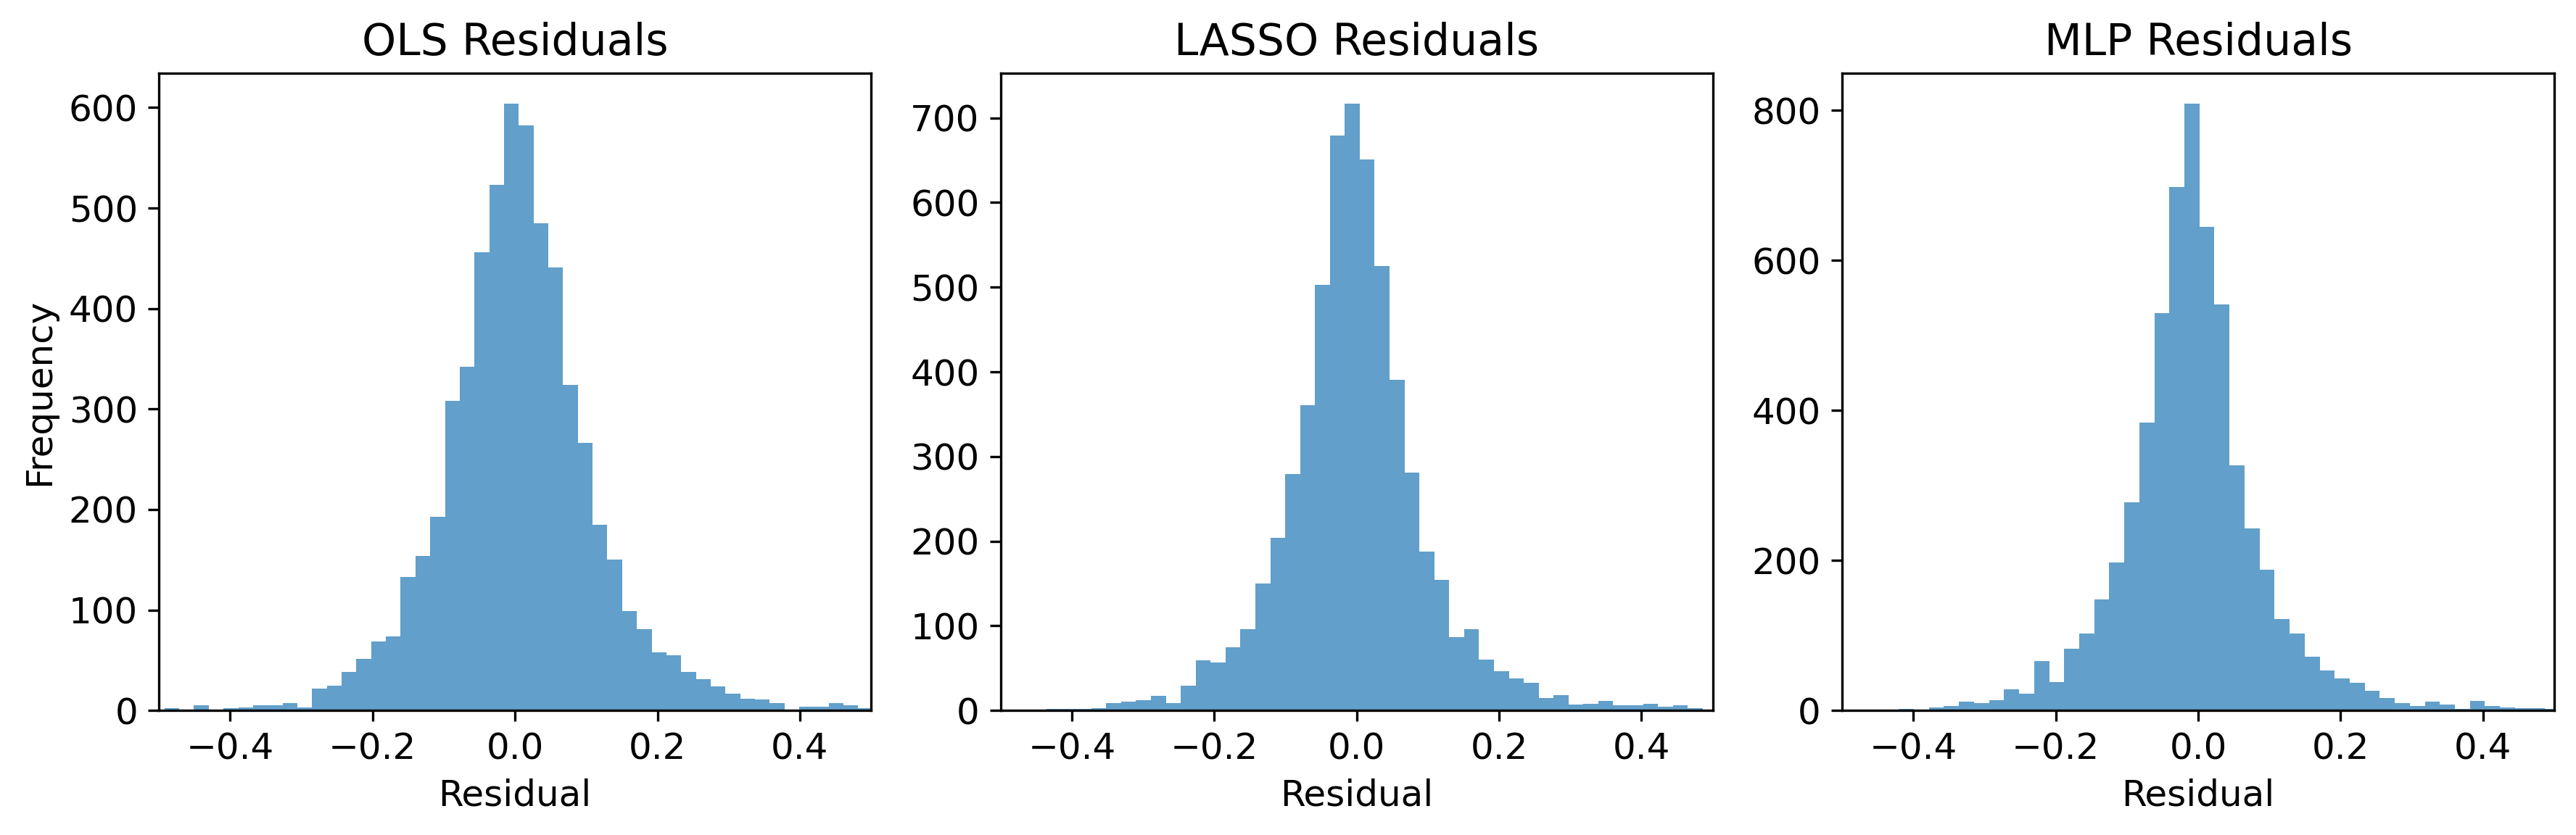

In [ ]:
# # define plot limits
# y_min, y_max = -0.5, 0.5
# bins = 500

# # Compute residuals
# res_ols   = all_preds['y_true'] - all_preds['OLS']
# res_lasso = all_preds['y_true'] - all_preds['LASSO']
# res_mlp   = all_preds['y_true'] - all_preds['MLP']

# # Plot histograms
# plt.figure(figsize=(12, 4))

# plt.subplot(1, 3, 1)
# plt.hist(res_ols, bins=bins, alpha=0.7)
# plt.xlabel('Residual')
# plt.ylabel('Frequency')
# plt.title('OLS Residuals')
# plt.xlim(y_min, y_max)

# plt.subplot(1, 3, 2)
# plt.hist(res_lasso, bins=bins, alpha=0.7)
# plt.xlabel('Residual')
# plt.title('LASSO Residuals')
# plt.xlim(y_min, y_max)

# plt.subplot(1, 3, 3)
# plt.hist(res_mlp, bins=bins, alpha=0.7)
# plt.xlabel('Residual')
# plt.title('MLP Residuals')
# plt.xlim(y_min, y_max)

# plt.tight_layout()
# plt.show()
